# OOI Pioneer Profiler Moorings

Taking [OOI Pioneer array data](https://dataexplorer.oceanobservatories.org) and wiriting it in [`profiles`](https://mitgcm.readthedocs.io/en/latest/ocean_state_est/ocean_state_est.html#profiles-model-data-comparisons-at-observed-locations) package format.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import xmitgcm

import os
import warnings
warnings.simplefilter('ignore')
os.environ['PYTHONWARNOINGS'] = 'ignore'

## Load OOI DataSets

In [3]:
def readOOI (fname):
    ds = xr.open_dataset(fname)
    ds = ds.rename({    'row':'iPROF', 
                        'sea_water_temperature_profiler_depth_enabled': 'prof_T',
                        'sea_water_temperature_profiler_depth_enabled_qc_agg':'prof_Tflag',
                        'sea_water_practical_salinity_profiler_depth_enabled': 'prof_S',
                        'sea_water_practical_salinity_profiler_depth_enabled_qc_agg':'prof_Sflag',})\
            .drop({     'sea_water_density_profiler_depth_enabled',
                        'sea_water_density_profiler_depth_enabled_qc_agg',
                        'sea_water_pressure_profiler_depth_enabled',
                        'sea_water_pressure_profiler_depth_enabled_qc_agg',})
    ds['prof_depth'] = xr.DataArray(-1 * ds.z, dims=ds.z.dims, attrs=ds.z.attrs)
    ds=ds.drop('z')
    return ds

In [4]:
dataPath = '/scratch2/shared/ooi-pioneer/'
dataFiles = os.listdir(dataPath)[5:]

In [5]:
xr.open_dataset(dataPath + 'cp01cnpm')

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch2/shared/ooi-pioneer/cp01cnpm'

In [4]:
ds = {}
for file in dataFiles:
    ds[file[0 : file.index('.')]] = readOOI(dataPath + file)

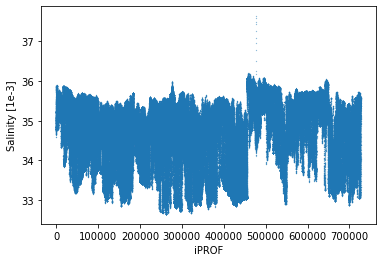

In [5]:
ds['cp01cnpm'].prof_S.plot(x='iPROF',
                              marker='o', linewidth=0.,
                              markersize=0.2)

## Write iPROFs

In [6]:
def writeTimeVariables (ds):
    times = ds.time.values.astype('datetime64[s]')
    yyyymmdd = []; hhmmss = []
    for time in times:
        tmp = str(time).partition('T')
        yyyymmdd.append( float(''.join( tmp[0].split("-", maxsplit=2) )) )
        hhmmss.append( float(''.join( tmp[-1].split(":", maxsplit=2) )) )
        
    ds['prof_YYYYMMDD'] = xr.DataArray(
                            yyyymmdd, dims=["iPROF"],
                            attrs={'long_name' : 'year (4 digits), month (2 digits), day (2 digits)'}
                        )
    ds['prof_HHMMSS'] = xr.DataArray(
                            hhmmss, dims=["iPROF"],
                            attrs={'long_name' : 'hour (2 digits), minute (2 digits), second (2 digits)'}
                        )
    return None

In [10]:
dsTest = ds['cp04ospm']
dsTest.prof_depth.attrs['actual_range']

array([-426.,    0.])

In [11]:
writeTimeVariables(dsTest)

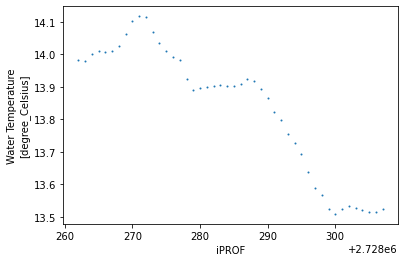

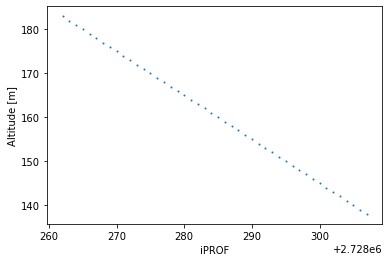

In [51]:
dsTest2 = dsTest.where(dsTest.time == np.datetime64('2019-06-22T21:06:00.000000000'))
dsTest2.prof_T.plot(marker='o', linewidth=0., markersize=1)
plt.show()
dsTest2.prof_depth.plot(marker='o', linewidth=0., markersize=1)
plt.show()

In [52]:
(unique, counts) = np.unique(dsTest.time, return_counts=True)
unique[np.where(counts == max(counts))[0]]

array(['2019-06-22T21:06:00.000000000'], dtype='datetime64[ns]')

In [43]:
dsTest2.sel(iPROF=slice(132,148))

<xarray.Dataset>
Dimensions:        (iPROF: 16)
Dimensions without coordinates: iPROF
Data variables:
    time           (iPROF) datetime64[ns] 2014-04-15T20:10:00 ... 2014-04-15T...
    prof_S         (iPROF) float64 35.55 35.55 35.55 35.54 ... 35.54 35.54 35.54
    prof_T         (iPROF) float64 12.55 12.55 12.54 12.52 ... 12.5 12.5 12.5
    prof_Sflag     (iPROF) float64 nan nan nan nan nan ... nan nan nan nan nan
    prof_Tflag     (iPROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    prof_depth     (iPROF) float64 168.0 167.0 166.0 165.0 ... 155.0 154.0 153.0
    prof_YYYYMMDD  (iPROF) float64 2.014e+07 2.014e+07 ... 2.014e+07 2.014e+07
    prof_HHMMSS    (iPROF) float64 2.01e+05 2.01e+05 ... 2.01e+05 2.01e+05
Attributes:
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    contributor_role:              processor
    contributor_role_vocabulary:   NERC
    contributor_url:               https://www.axiomdatascience.com
    Conventions:                   IOOS-1.2, CF-1.6, ACDD-1.3
    creator_institution:           Ocean Observatories Initiative (OOI)
    creator_name:                  Ocean Observatories Initiative (OOI)
    creator_sector:                gov_federal
    creator_type:                  institution
    creator_url:                   https://oceanobservatories.org/
    defaultDataQuery:              sea_water_practical_salinity_profiler_dept...
    featureType:                   TimeSeriesProfile
    geospatial_lat_units:          degrees_north
    geospatial_lon_units:          degrees_east
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m
    history:                       Downloaded from Ocean Observatories Initia...
    id:                            103952
    infoUrl:                       https://sensors.ioos.us/#metadata/103952/s...
    institution:                   Ocean Observatories Initiative (OOI)
    license:                       The data may be used and redistributed for...
    naming_authority:              com.axiomdatascience
    platform:                      profiling_buoy
    platform_name:                 Coastal Pioneer: Offshore Profiler Mooring...
    platform_vocabulary:           http://mmisw.org/ont/ioos/platform
    processing_level:              Level 2
    publisher_institution:         Ocean Observatories Initiative (OOI)
    publisher_name:                Ocean Observatories Initiative (OOI)
    publisher_sector:              gov_federal
    publisher_type:                institution
    publisher_url:                 https://oceanobservatories.org/
    references:                    https://ooinet.oceanobservatories.org/data...
    sourceUrl:                     https://ooinet.oceanobservatories.org/data...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    103952
    summary:                       Timeseries data from 'Coastal Pioneer: Off...
    time_coverage_end:             2021-08-22T18:19:00Z
    time_coverage_start:           2014-04-15T20:00:00Z
    title:                         Coastal Pioneer: Offshore Profiler Mooring...

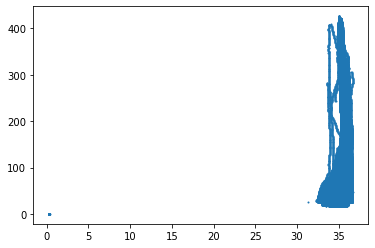

In [15]:
test = dsTest.prof_S.where( (dsTest.prof_depth < 27) & \
                     (dsTest.prof_depth >=26))


plt.figure()
plt.scatter(dsTest.prof_S, dsTest.prof_depth, s=1)
plt.show()

In [ ]:
#bin the data in depth based bins